Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
!pip install -U -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


Runtime Parameters

In [3]:
airline_to_run = 'OO'

___
# 1.) Download Data

## S3 parameters

In [4]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [5]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [6]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [7]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [8]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [10]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [11]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [12]:
df_toTrain = df.loc[df['UNIQUE_CARRIER'] == airline_to_run]

distinct_airlines = df_toTrain.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_toTrain.shape[0], df_toTrain.shape[1], distinct_airlines))

New dataset has 583694 records with 22 variables, containing only airlines ['OO']


In [13]:
df_toTrain

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
322912,2007-01-01,2007,1,1,1,OO,SUN,SLC,08:13:00,-2.0,...,53.0,223.0,09:23:00,-2.0,NaN,NaN,NaN,NaN,NaN,late
322913,2007-01-01,2007,1,1,1,OO,SLC,SUN,07:54:00,-6.0,...,48.0,223.0,09:04:00,-3.0,NaN,NaN,NaN,NaN,NaN,late
322914,2007-01-01,2007,1,1,1,OO,SUN,SLC,09:31:00,3.0,...,60.0,223.0,10:45:00,10.0,NaN,NaN,NaN,NaN,NaN,late
322915,2007-01-01,2007,1,1,1,OO,SLC,PIH,08:08:00,-7.0,...,42.0,150.0,09:10:00,-8.0,NaN,NaN,NaN,NaN,NaN,late
322916,2007-01-01,2007,1,1,1,OO,PIH,SLC,09:41:00,4.0,...,47.0,150.0,10:49:00,14.0,NaN,NaN,NaN,NaN,NaN,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7064578,2007-12-31,2007,12,31,1,OO,SGF,DEN,06:23:00,-7.0,...,119.0,637.0,07:40:00,7.0,NaN,NaN,NaN,NaN,NaN,late
7064579,2007-12-31,2007,12,31,1,OO,LNK,DEN,06:53:00,-7.0,...,78.0,423.0,07:24:00,-16.0,NaN,NaN,NaN,NaN,NaN,late
7064580,2007-12-31,2007,12,31,1,OO,DEN,FAR,16:44:00,73.0,...,86.0,627.0,19:32:00,73.0,0.0,0.0,0.0,0.0,73.0,late
7064581,2007-12-31,2007,12,31,1,OO,FAR,DEN,20:00:00,60.0,...,87.0,627.0,20:45:00,45.0,45.0,0.0,0.0,0.0,0.0,late


___
# 2.) Explorational Data Analysis

## Distribution of Target (dependent) Variable `late_flight`

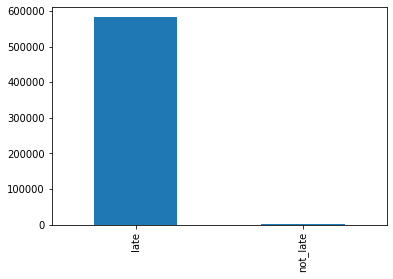

In [14]:
df_toTrain.late_flight.value_counts().plot(kind='bar')

In [15]:
df_toTrain.late_flight.value_counts()

late        581857
not_late      1837
Name: late_flight, dtype: int64

**NOTE** Looks like a pretty imbalance distribution of target variable.  Will probably need to use SMOTE and create synthetic data for the minority class.

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

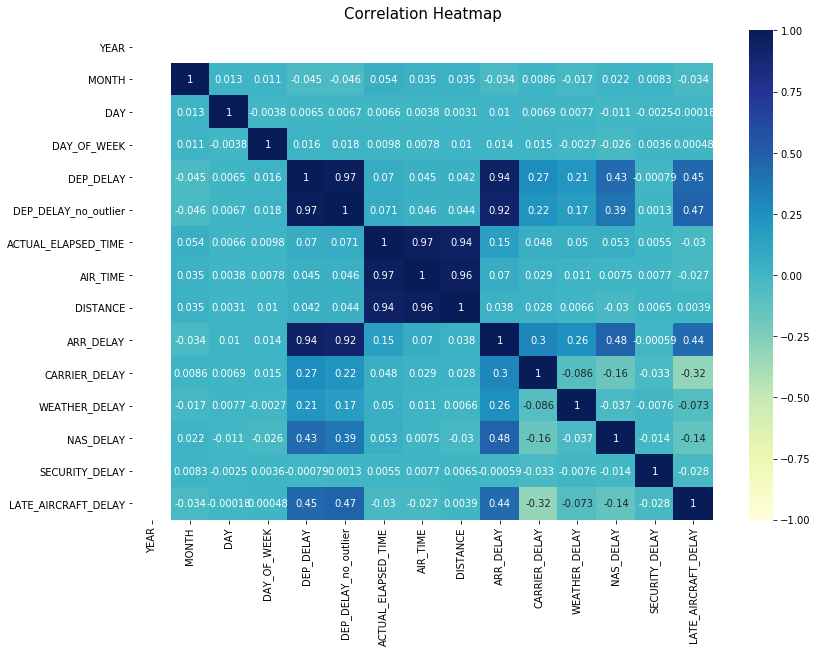

In [16]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_toTrain.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

**NOTE** Looks like high correlation between:
  - `DEP_DELAY_no_outlier` :: `ARR_DELAY`, which could makes logical sense because if you are late departing, then you are likely to be late arriving
  - `ACTUAL_ELAPSED_TIME` :: `DISTANCE` :: `AIR_TIME`, which make sense as each 3-variables are referencing same part of flight

# 3.) Train Model

In [17]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pyldavis 3.3.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
ERROR: pandas-profiling 2.12.0 has requirement matplotlib>=3.2.0, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: pandas-profiling 2.12.0 has requirement tqdm>=4.48.2, but you'll have tqdm 4.42.1 which is incompatible.


## a. Get the Data

In [18]:
data = df_toTrain.sample(frac=0.12, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (70043, 22)
Unseen Data For Predictions: (7224606, 22)


## b. Setting Up Environment in PyCaret

In [20]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR', 'MONTH','DAY','DAY_OF_WEEK'],
            ignore_features = ['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', 'ARR_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,6101
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(70043, 22)"
5,Missing Values,True
6,Numeric Features,11
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


## c. Comparing all models

In [31]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

# best_model = compare_models(cross_validation=False)
best_model = compare_models(fold=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9963,0.5000,0.0000,0.0000,0.0000,-0.0000,-0.0002,4.7933
rf,Random Forest Classifier,0.9962,0.9170,0.0056,0.1111,0.0106,0.0103,0.0241,13.2400
et,Extra Trees Classifier,0.9959,0.7137,0.0056,0.0370,0.0097,0.0088,0.0130,9.9633
lightgbm,Light Gradient Boosting Machine,0.9947,0.9792,0.0334,0.0627,0.0433,0.0410,0.0432,2.0367
dt,Decision Tree Classifier,0.9922,0.5396,0.0837,0.0642,0.0726,0.0687,0.0694,7.2733
knn,K Neighbors Classifier,0.9746,0.5518,0.0893,0.0146,0.0251,0.0189,0.0274,182.5033
nb,Naive Bayes,0.9717,0.7018,0.4300,0.0563,0.0996,0.0938,0.1479,0.6333
ada,Ada Boost Classifier,0.9661,0.9760,0.6538,0.0689,0.1246,0.1188,0.2047,10.1767
gbc,Gradient Boosting Classifier,0.9646,0.9762,0.7205,0.0714,0.1298,0.1240,0.2195,41.3167
lr,Logistic Regression,0.8860,0.7194,0.3294,0.0106,0.0205,0.0135,0.0412,12.2967


# 4.) Create Model(s)

## a. Random Forest Classifier

In [32]:
rf = create_model('rf')
# rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
# print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9964,0.9397,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9962,0.9175,0.0000,0.0000,0.0000,-0.0002,-0.0005
Mean,0.9963,0.9286,0.0000,0.0000,0.0000,-0.0001,-0.0003
SD,0.0001,0.0111,0.0000,0.0000,0.0000,0.0001,0.0003


## b. Extra Trees Classifier

In [33]:
et = create_model('et')
# et = create_model('et', cross_validation=False)

# trained model object is stored as `et`
# print(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9962,0.7287,0.0000,0.0000,0.0000,-0.0004,-0.0009
1,0.9958,0.7139,0.0000,0.0000,0.0000,-0.0009,-0.0013
Mean,0.9960,0.7213,0.0000,0.0000,0.0000,-0.0006,-0.0011
SD,0.0002,0.0074,0.0000,0.0000,0.0000,0.0002,0.0002


## c. Light Gradient Boosting Machine

In [34]:
lightgbm = create_model('lightgbm')
# lightgbm = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
# print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9954,0.9805,0.0225,0.0714,0.0342,0.0325,0.0381
1,0.9947,0.9801,0.0111,0.0238,0.0152,0.0128,0.0138
Mean,0.9950,0.9803,0.0168,0.0476,0.0247,0.0227,0.0260
SD,0.0003,0.0002,0.0057,0.0238,0.0095,0.0098,0.0122


# 5.) Tune Model(s)

## a. Random Forest Classifer

In [35]:
tuned_rf = tune_model(rf, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_rf`
# print(tuned_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9617,0.9751,0.7865,0.0707,0.1297,0.1239,0.2288
1,0.9706,0.9402,0.6111,0.0743,0.1325,0.1268,0.2061
Mean,0.9662,0.9576,0.6988,0.0725,0.1311,0.1254,0.2174
SD,0.0045,0.0175,0.0877,0.0018,0.0014,0.0015,0.0113


## b. Extra Tree Classifier

In [36]:
tuned_et = tune_model(et, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_et`
# print(tuned_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9769,0.9345,0.4831,0.0764,0.1319,0.1264,0.1854
1,0.9670,0.9760,0.7333,0.0776,0.1404,0.1347,0.2318
Mean,0.9720,0.9553,0.6082,0.0770,0.1362,0.1306,0.2086
SD,0.0049,0.0207,0.1251,0.0006,0.0043,0.0041,0.0232


## c. Light Gradient Boosting Machine

In [37]:
tuned_lightgbm = tune_model(lightgbm, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_lightgbm`
# print(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9956,0.9803,0.0112,0.0500,0.0183,0.0170,0.0220
1,0.9956,0.9806,0.0000,0.0000,0.0000,-0.0013,-0.0017
Mean,0.9956,0.9805,0.0056,0.0250,0.0092,0.0079,0.0102
SD,0.0000,0.0001,0.0056,0.0250,0.0092,0.0092,0.0119


# 6.) Models Performance

## a. Light Gradient Boosting Machine

### i. Confusion Matrix

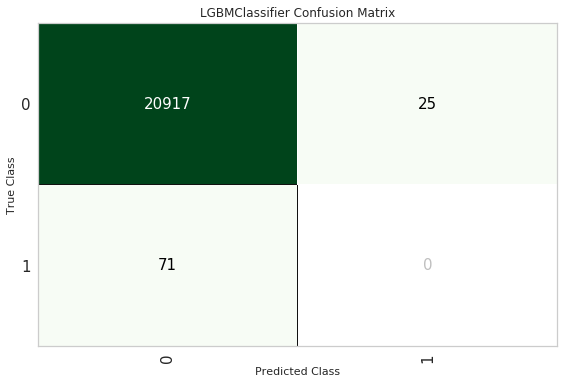

In [38]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

### ii. Features Importance

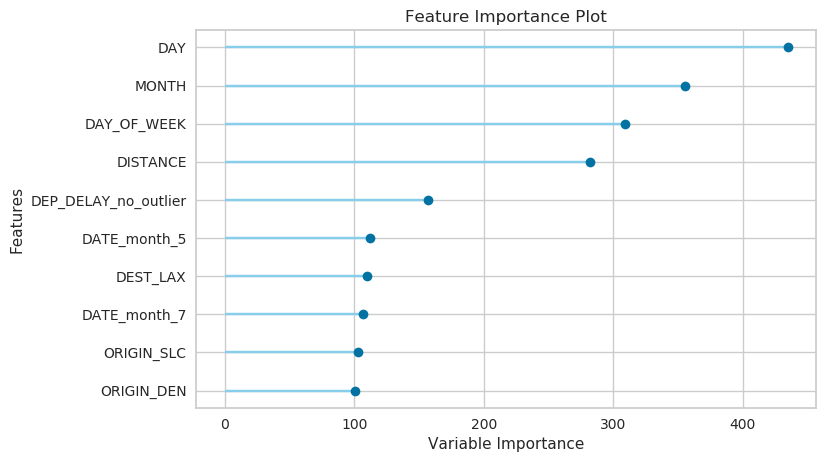

In [39]:
plot_model(tuned_lightgbm, plot='feature')

Features that has greatest explanatory power are:

* ~`ACTUAL_ELAPSED_TIME`~
* `DAY` of the month
* `Month`

### iii. Intrepret Model's with SHAP

ref. 

* https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/
* https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/?utm_source=blog&utm_medium=pycaret-machine-learning-model-seconds

In [40]:
!apt-get update && apt-get install -y build-essential -q
!python -m pip install -q shap

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease
Reading package lists... Done
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


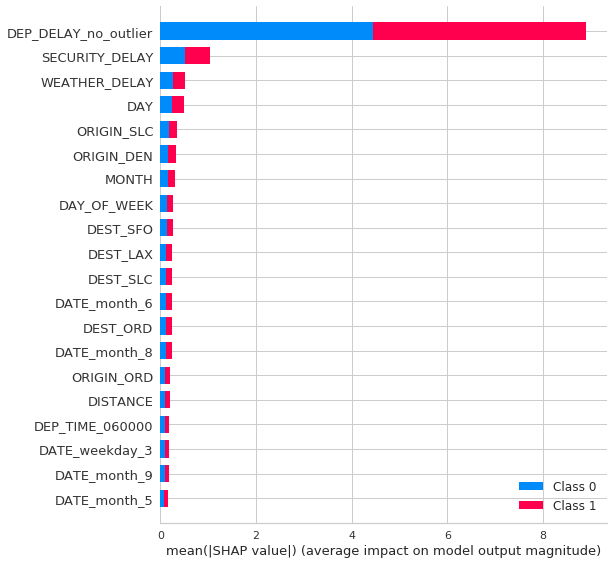

In [41]:
interpret_model(tuned_lightgbm, plot='summary')

In [ ]:
interpret_model(tuned_lightgbm, plot='correlation')

# 8.) Predict of Test Data Sample

## a. Light Gradient Boosting Machine

In [42]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9954,0.9768,0.0000,0.0000,0.0000,-0.0018,-0.0020


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,...,DATE_weekday_1,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,late_flight,Label,Score
0,1.006780,0.484253,1.026420,-0.093828,1.345056,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
1,-0.473603,-0.545422,0.535681,0.540939,0.247819,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,late,late,0.9999
2,-0.182372,-1.003663,0.038809,-1.020283,-1.041654,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,0.9999
3,0.111408,-0.774506,-1.493920,0.210757,-1.450199,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
4,1.006780,-0.774506,-0.977576,-1.179614,0.625685,0.183095,0.447347,0.377612,0.50504,0.223254,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21008,-0.473603,-1.576820,-0.466118,-1.020283,0.461569,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
21009,1.611924,1.512161,1.026420,-0.868014,-0.089584,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
21010,0.407835,-1.576820,0.038809,-0.207051,1.018020,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,0.9999
21011,-0.762803,0.484253,0.535681,-1.346163,-0.717416,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,late,late,0.9999


# 9.) Deploy Model (finalized)

## a. Light Gradient Boosting Machine

In [43]:
final_lightgbm = finalize_model(tuned_lightgbm)

#Final model's parameters for deployment
print(final_lightgbm)

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=

**Caution**: Once the model is finalized using `finalize_model()`, the entire dataset including the test/hold-out set is used for training. As a result, if the model is used for predictions on the hold-out set after `finalize_model()` is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

In [44]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9976,0.9976,0.3803,0.8182,0.5192,0.5182,0.5569


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,...,DATE_weekday_1,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,late_flight,Label,Score
0,1.006780,0.484253,1.026420,-0.093828,1.345056,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
1,-0.473603,-0.545422,0.535681,0.540939,0.247819,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,late,late,0.9999
2,-0.182372,-1.003663,0.038809,-1.020283,-1.041654,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,0.9999
3,0.111408,-0.774506,-1.493920,0.210757,-1.450199,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
4,1.006780,-0.774506,-0.977576,-1.179614,0.625685,0.183095,0.447347,0.377612,0.50504,0.223254,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21008,-0.473603,-1.576820,-0.466118,-1.020283,0.461569,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
21009,1.611924,1.512161,1.026420,-0.868014,-0.089584,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
21010,0.407835,-1.576820,0.038809,-0.207051,1.018020,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,1.0000
21011,-0.762803,0.484253,0.535681,-1.346163,-0.717416,0.183095,0.447347,0.377612,0.50504,0.223254,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,late,late,1.0000


# 10.) Predict on Unseen Dataset

In [45]:
# Decrease size of unseen data `data_unseen` by sampling 168 random rows
data_unseen_mini = data_unseen.sample(n = 168)

unseen_predictions = predict_model(final_lightgbm, data=data_unseen_mini)
unseen_predictions

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight,Label,Score
896763,2007-02-07,2007,2,7,3,OO,SLC,LGB,15:59:00,9.0,...,16:56:00,16.0,16.0,0.0,0.0,0.0,0.0,late,late,1.0000
1177529,2007-03-22,2007,3,22,4,AA,AUS,DFW,08:27:00,-3.0,...,09:47:00,17.0,0.0,0.0,17.0,0.0,0.0,late,late,1.0000
4615273,2007-08-17,2007,8,17,5,UA,DEN,LAX,14:22:00,-3.0,...,15:26:00,-21.0,NaN,NaN,NaN,NaN,NaN,late,late,1.0000
159886,2007-01-24,2007,1,24,3,DL,RDU,ATL,17:10:00,-5.0,...,18:40:00,-6.0,NaN,NaN,NaN,NaN,NaN,late,late,1.0000
3669881,2007-07-05,2007,7,5,4,B6,JFK,LGB,17:12:00,-3.0,...,20:53:00,20.0,0.0,0.0,20.0,0.0,0.0,late,late,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383377,2007-06-09,2007,6,9,6,US,PHX,BWI,12:19:00,9.0,...,19:25:00,-18.0,NaN,NaN,NaN,NaN,NaN,late,late,0.9999
5450516,2007-10-26,2007,10,26,5,AA,LAX,MIA,22:33:00,8.0,...,06:31:00,16.0,0.0,0.0,16.0,0.0,0.0,late,late,1.0000
1559921,2007-03-15,2007,3,15,4,US,GEG,PHX,08:07:00,-8.0,...,10:29:00,-19.0,NaN,NaN,NaN,NaN,NaN,late,late,1.0000
5211142,2007-09-21,2007,9,21,5,UA,MCI,DEN,08:43:00,-2.0,...,09:25:00,-15.0,NaN,NaN,NaN,NaN,NaN,late,late,1.0000


In [47]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
KPI_score = check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'], metric=KPI)


print('The {0} of `lightgbm` model is {1}.'.format(KPI, KPI_score))

The Accuracy of `lightgbm` model is 0.9821.


# 11.) Persist Model

In [48]:
today = datetime.datetime.now()
today_datetime = today.strftime("%d-%m-%Y %H:%M:%S")
pkl_filename = 'Final_model___' + 'lightgbm' + '___for_' + airline_to_run + '_' + today_datetime

save_model(final_lightgbm, pkl_filename)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['DEP_DELAY', 'ARR_DELAY',
                                                        'AIR_TIME',
                                                        'ACTUAL_ELAPSED_TIME',
                                                        'ARR_TIME'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['YEAR', 'MONTH',
                                                           'DAY',
                                                           'DAY_OF_WEEK'],
                                       target='late_flight', time_features=[])),
                 ('imputer',
                  Simple_Impute...
                                 boosting_ty

# 12.) Load a Saved Model

In [49]:
# REMEMBER to omit file suffix ".pkl"
model_to_load = 'Final_model___lightgbm___for_OO_07-05-2021 13:55:13'

saved_model = load_model(model_to_load)

Transformation Pipeline and Model Successfully Loaded


In [50]:
# Decrease size of unseen data `data_unseen` by sampling 168 random rows
data_unseen_mini = data_unseen.sample(n = 168)

new_prediction = predict_model(saved_model, data=data_unseen_mini)
new_prediction.head()

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight,Label,Score
896763,2007-02-07,2007,2,7,3,OO,SLC,LGB,15:59:00,9.0,...,16:56:00,16.0,16.0,0.0,0.0,0.0,0.0,late,late,1.0
1177529,2007-03-22,2007,3,22,4,AA,AUS,DFW,08:27:00,-3.0,...,09:47:00,17.0,0.0,0.0,17.0,0.0,0.0,late,late,1.0
4615273,2007-08-17,2007,8,17,5,UA,DEN,LAX,14:22:00,-3.0,...,15:26:00,-21.0,NaN,NaN,NaN,NaN,NaN,late,late,1.0
159886,2007-01-24,2007,1,24,3,DL,RDU,ATL,17:10:00,-5.0,...,18:40:00,-6.0,NaN,NaN,NaN,NaN,NaN,late,late,1.0
3669881,2007-07-05,2007,7,5,4,B6,JFK,LGB,17:12:00,-3.0,...,20:53:00,20.0,0.0,0.0,20.0,0.0,0.0,late,late,1.0


In [51]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
KPI_score = check_metric(new_prediction['late_flight'], new_prediction['Label'], metric=KPI)


print('The {0} of `lightgbm` model is {1}.'.format(KPI, KPI_score))

The Accuracy of `lightgbm` model is 0.9821.
